In [8]:
import sys
import os

import pandas as pd 
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import torch.optim as optim
from torch import nn, einsum
from torch.utils.data import DataLoader

import utilities
torch.max_split_size_mb = 4096
device = torch.device("cuda:0")

from mixture_of_experts import MoE

In [9]:
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'decaalanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)
"""
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')
"""
whole_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = GLOBAL_BATCH_SIZE, #256 is the default batch size
                          shuffle = True)

for batch_idx, (whole_data, _) in enumerate(whole_loader):
    #Flatten the data into a tensor of size (batch_size, 300) tensor before putting it into the GPU
    whole_data = utilities.flatten_data(whole_data).to(device) #for deccalanine
    #tr_cov, tr_means, bonds_angles_dist = utilities.return_ba_mean_covar(data, dec=True)

In [10]:
original_np = np.array(whole_data.cpu())

In [ ]:
#reserved for futher usage
"""
#convert to unimodal step
m = torch.where(pi_dihedral < 0, pi_dihedral + 2*torch.pi, pi_dihedral)
m = m - torch.pi

#convert to divided step
m = torch.where(m < 0, m + torch.pi, m)
m = torch.where(m < 2, m - torch.pi, m)
"""

### Normalize The Data

In [28]:
def custom_bucketize(input_, num_bins, lower_bound = -torch.pi, upper_bound = torch.pi, right=True):
    bounds = torch.linspace(start=lower_bound, end=upper_bound, steps=num_bins).to(device)
    return torch.bucketize(input_, bounds).to(device)

def un_bucketize_dict(num_bins, lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = dict()
    data_range = upper_bound - lower_bound
    delta = data_range/num_bins
    lower_value = lower_bound + delta/2
    for iter in range(0, num_bins+1, 1):
        unbucket_dict[iter] = lower_value
        lower_value = lower_value + delta
    return unbucket_dict

def un_bucketize(input_, num_bins, device=torch.device('cuda:0'), 
                lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = un_bucketize_dict(num_bins, lower_bound=-torch.pi, upper_bound=torch.pi)
    np_input = input_.cpu().numpy()
    return torch.tensor( np.vectorize(unbucket_dict.get)(np_input) ).to(device)

def statistical_unbucketize(input_, num_bins, lower_bound=-torch.pi, upper_bound=torch.pi):
    """Unbucketize in a sampling operation"""
    data_linspace = torch.linspace(start=lower_bound, end=upper_bound, steps=GLOBAL_NUM_BINS+1)

    uniform_dist_dict = dict()
    data_range = 2*torch.pi
    delta = data_range/GLOBAL_NUM_BINS
    
    np_input = input_.cpu().numpy()
    
    for iter in range(0, GLOBAL_NUM_BINS, 1):
        lower_range = data_linspace[iter]
        upper_range = data_linspace[iter+1]
        uniform_dist_dict[iter] = torch.distributions.Uniform(lower_range, upper_range)
    
    sample_item = lambda item: item.sample()
    #resol = np.vectorize(sample_item)(result) 

    dist_array =  np.vectorize(uniform_dist_dict.get)(np_input)
    return np.vectorize(sample_item)(dist_array)

def return_unimodal_multimodal(flattened_data, normalize=False):
    "Given the flattened data, return the unimodal_data and the multimodal_dihedrals"
    flattened_data = flattened_data.to(device)
    bonds_angles = flattened_data[:, :-99].to(device)
    dihedrals = flattened_data[:, 201:].to(device)
    
    unimodal_dihedrals = torch.index_select(dihedrals, 1, unimodal_indx).to(device)
    pi_dihedrals = torch.index_select(dihedrals, 1, pi_indx).to(device)
    multi_dihedrals = torch.index_select(dihedrals, 1, multimodal_indx).to(device)    
        
    unimodal_data = torch.cat([bonds_angles, unimodal_dihedrals, pi_dihedrals], dim=1).to(device)
    
    return unimodal_data, multi_dihedrals

for bonds and angles, we calculate for each of them, the minimum value and the maximum value. then we transform them so that they are now distributed on the range 0 to 1.

$$z_i = \frac{x_i - min(x_i)}{max(x_i) - min(x_i)}$$

$$x_i = (max(x_i) - min(x_i)) * z_i + min(x_i)$$

In [36]:
maxs = torch.max(unimodal_whole_data, dim=1)
mins = torch.min(unimodal_whole_data, dim=1)
ranges = maxs.values - mins.values

### Reconstruct the Data

In [20]:
#process pi_angles
pi_dihedrals = torch.where(pi_dihedrals < 0, pi_dihedrals + torch.pi, pi_dihedrals)
pi_dihedrals = torch.where(pi_dihedrals < 2, pi_dihedrals - torch.pi, pi_dihedrals)

In [23]:
print(unimodal_dihedrals.size())

torch.Size([1000, 50])


In [26]:
total_dihedrals = torch.zeros(99).repeat(1000, 1).float() #torch.arange(0, 99, 1)
total_dihedrals[:, unimodal_indx[:]] = unimodal_dihedrals.float().cpu()
total_dihedrals[:, pi_indx[:]] = pi_dihedrals.float().cpu()
total_dihedrals[:, multimodal_indx[:]] = multi_dihedrals.float().cpu()

In [28]:
whole = torch.cat([bonds_angles.cpu(), total_dihedrals.cpu()], dim=1)

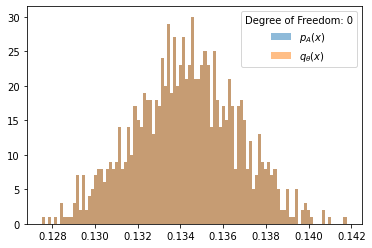

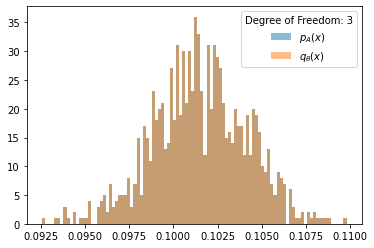

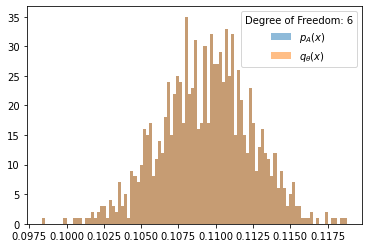

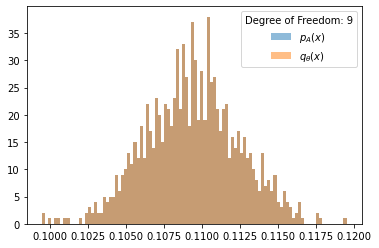

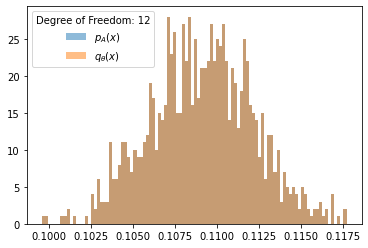

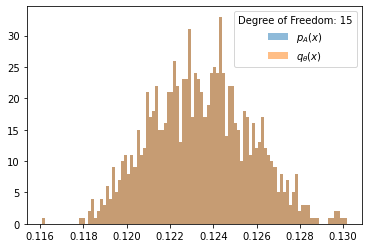

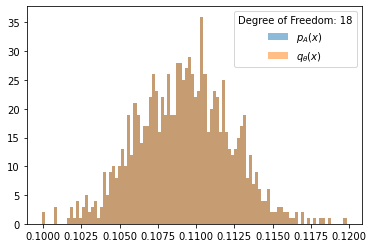

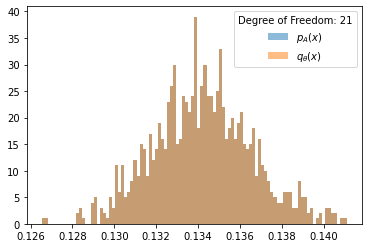

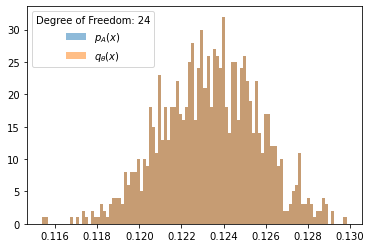

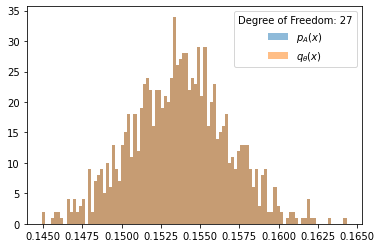

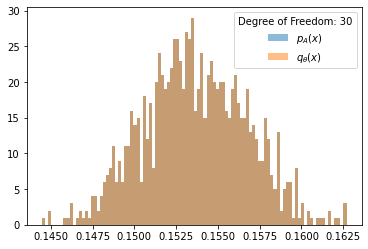

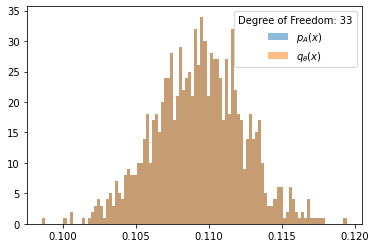

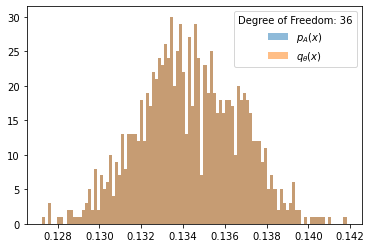

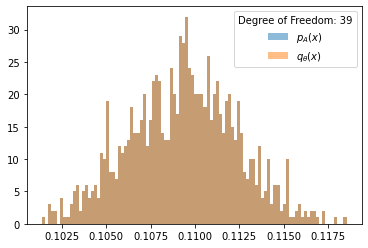

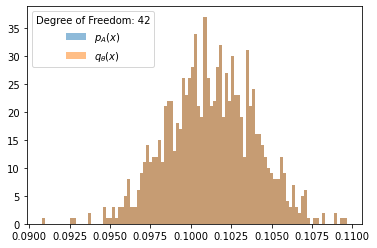

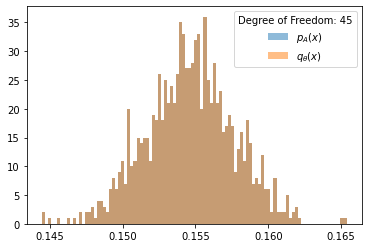

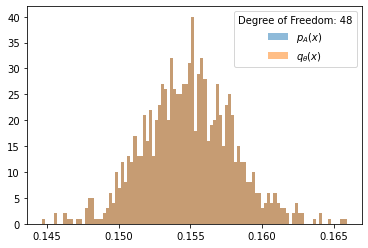

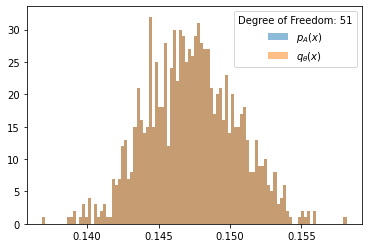

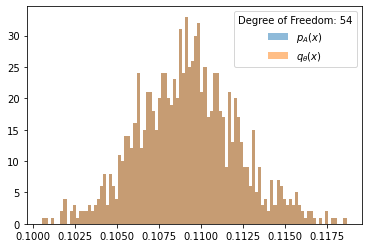

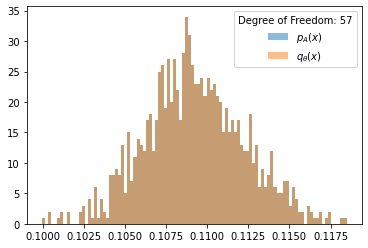

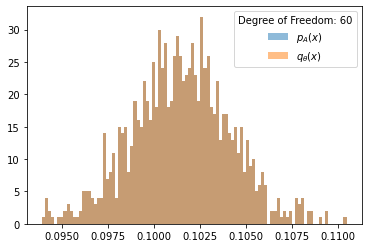

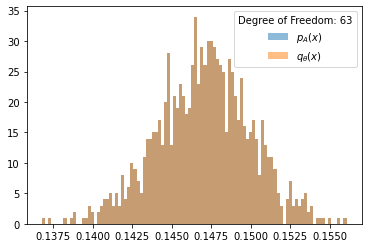

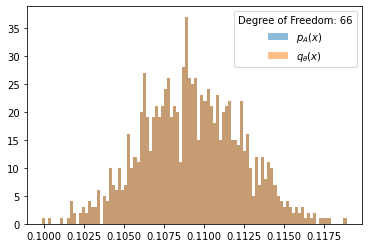

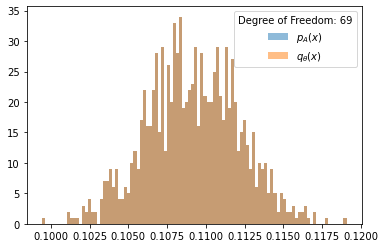

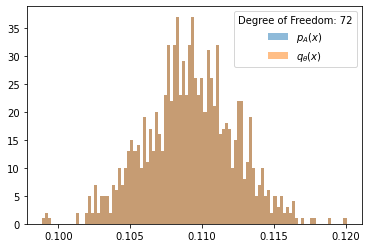

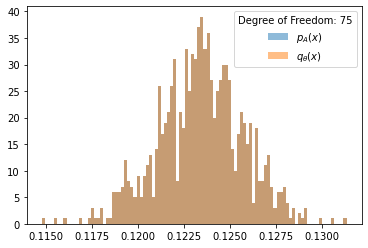

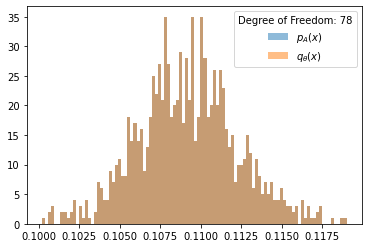

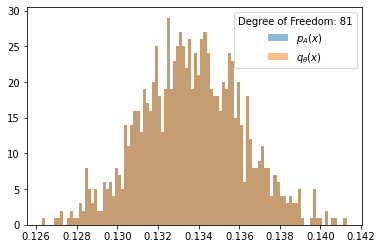

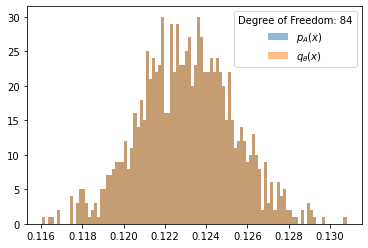

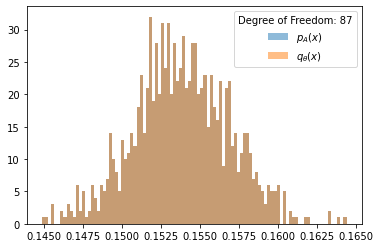

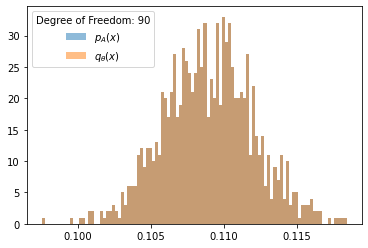

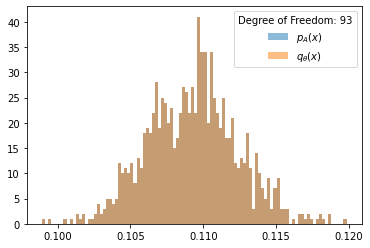

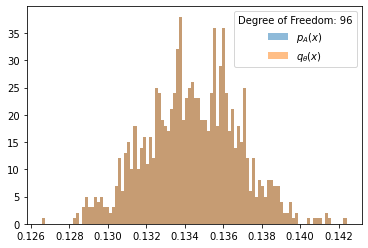

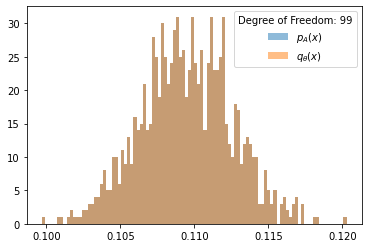

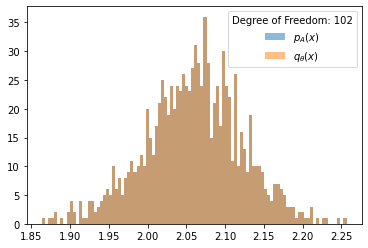

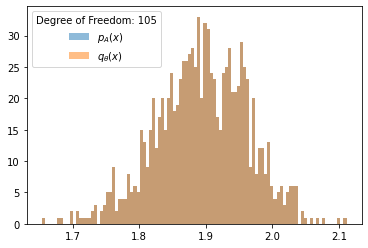

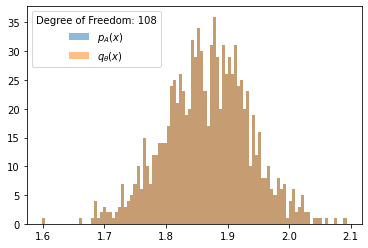

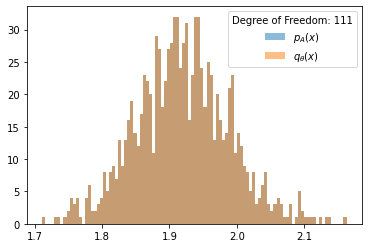

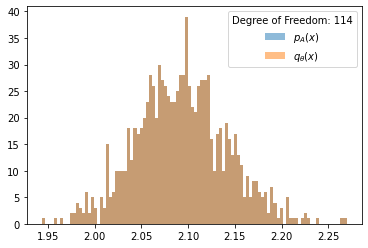

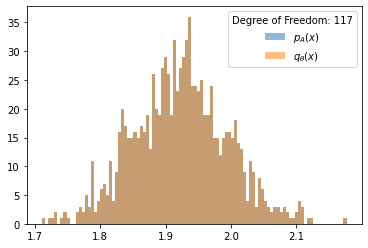

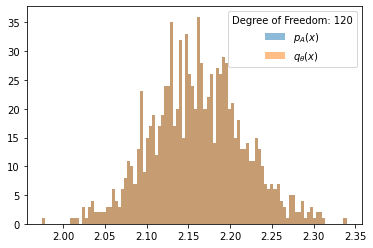

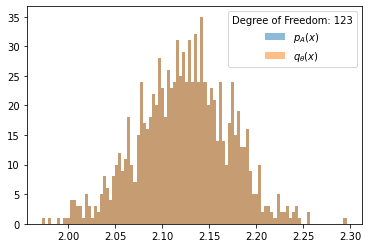

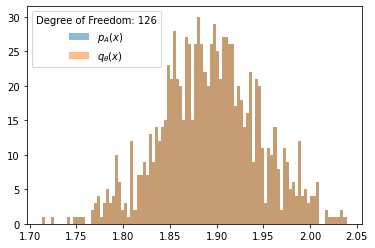

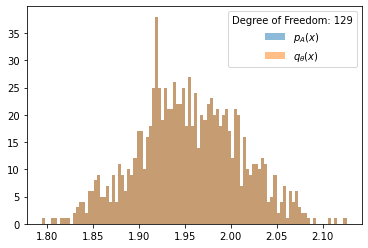

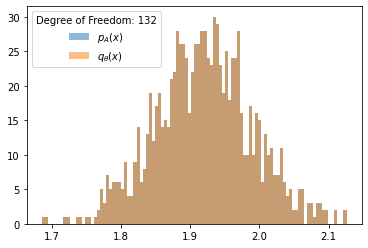

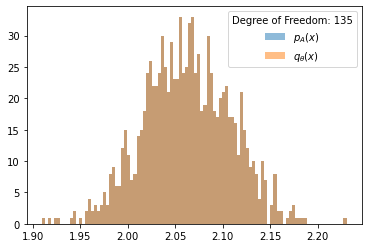

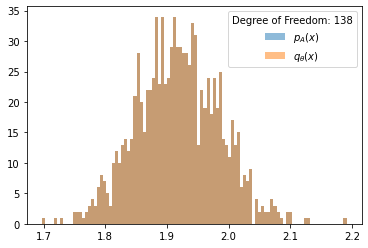

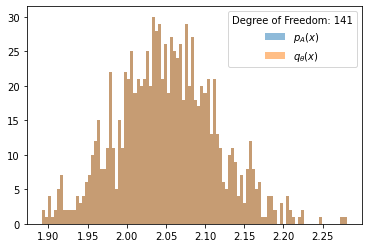

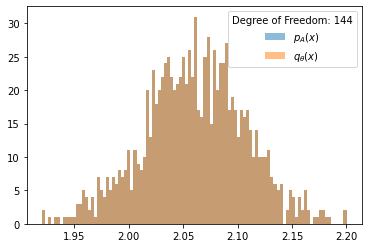

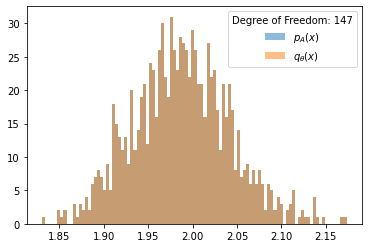

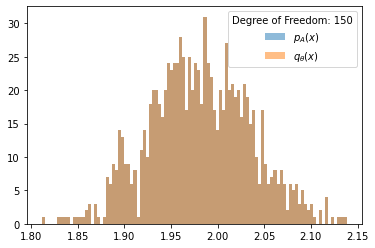

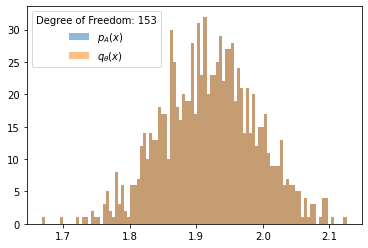

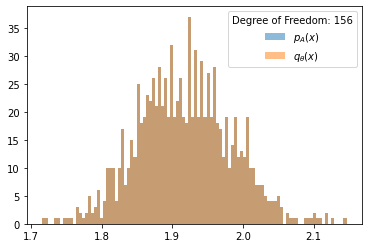

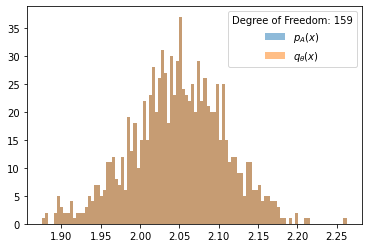

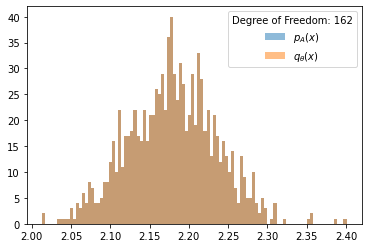

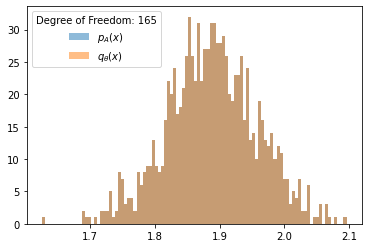

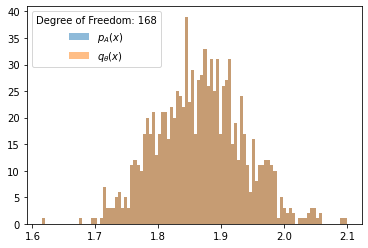

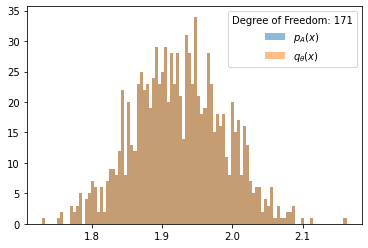

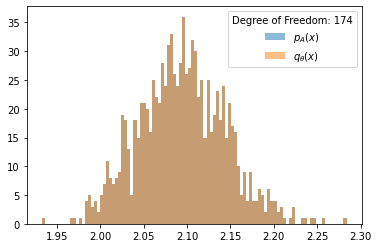

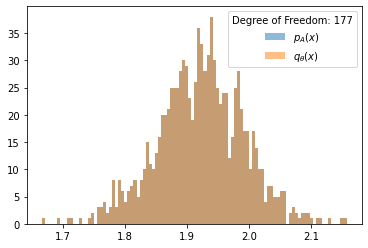

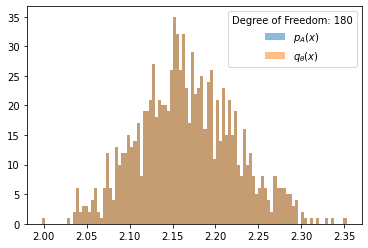

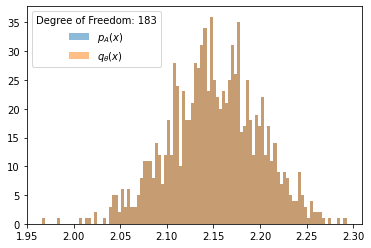

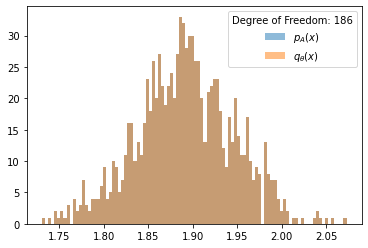

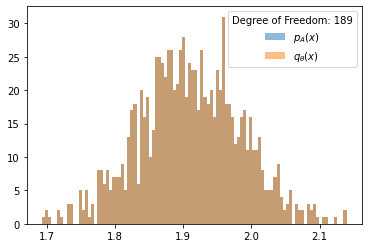

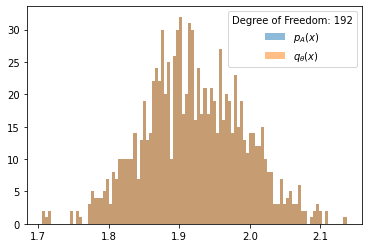

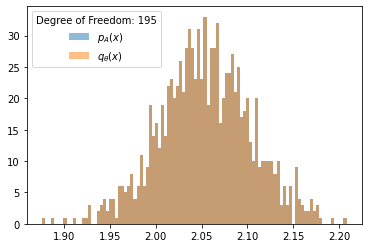

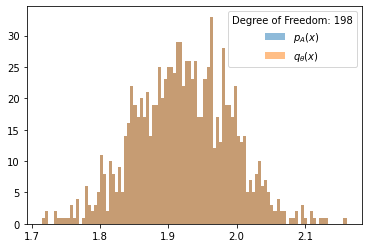

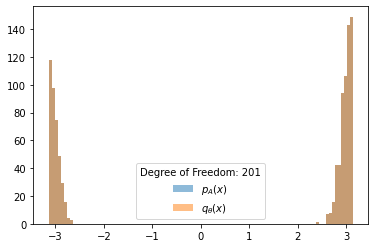

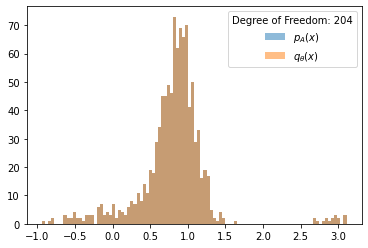

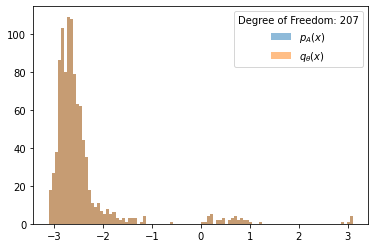

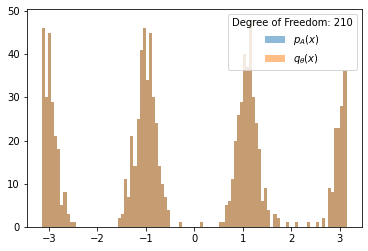

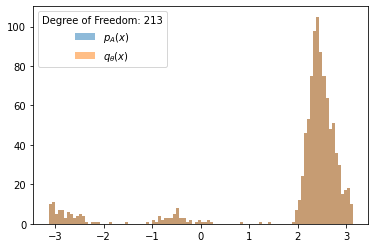

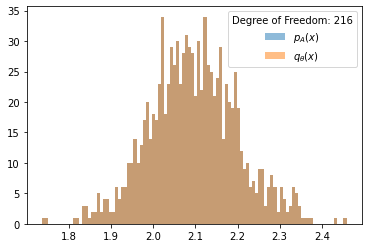

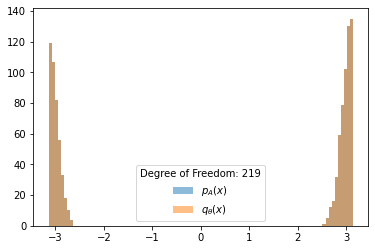

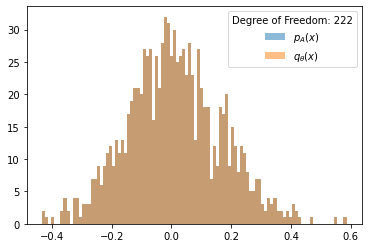

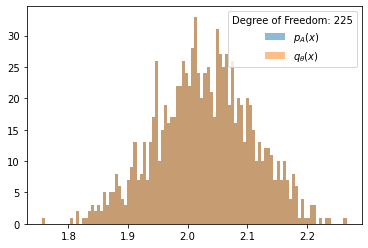

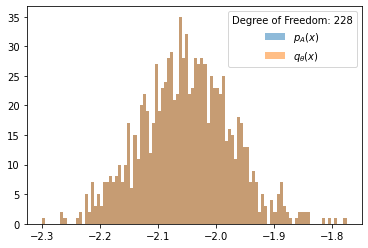

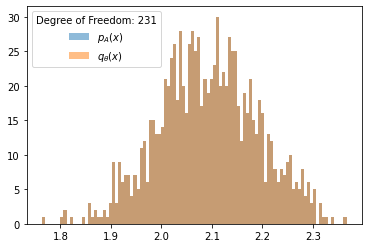

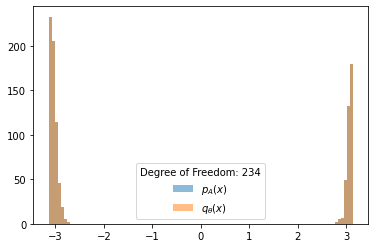

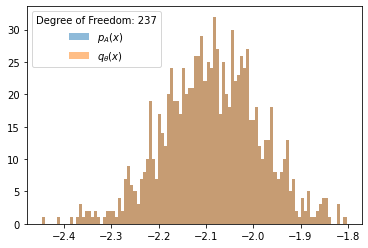

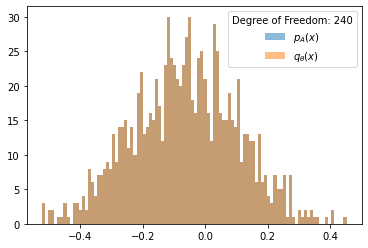

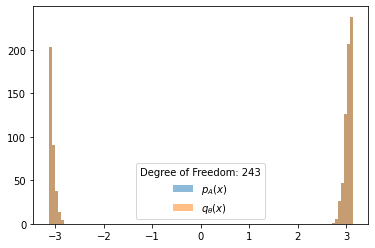

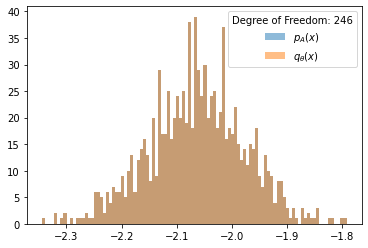

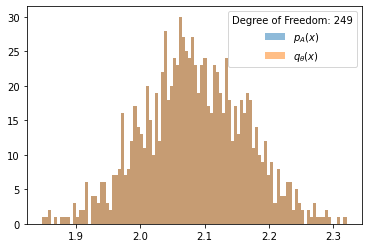

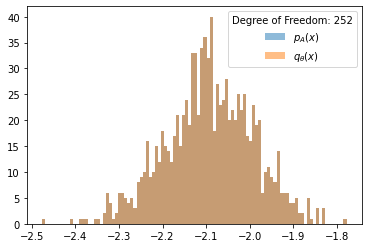

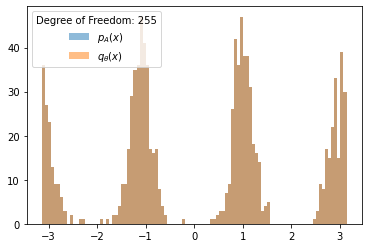

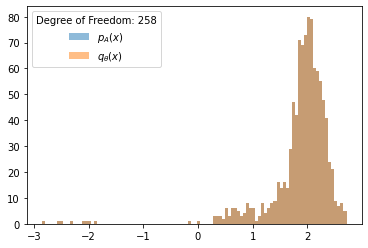

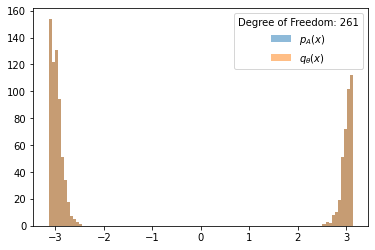

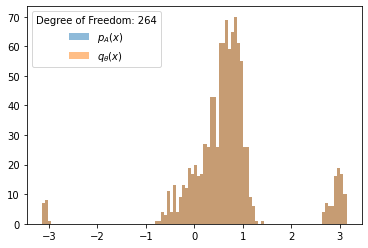

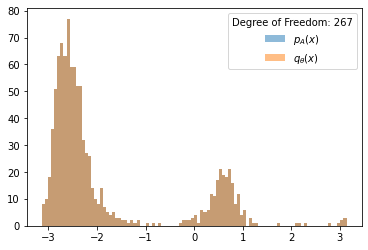

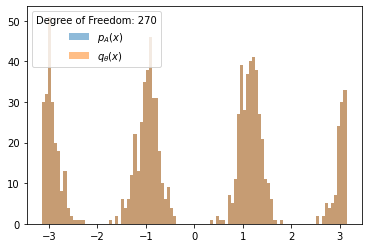

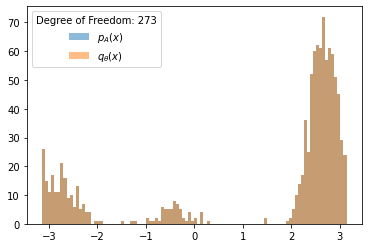

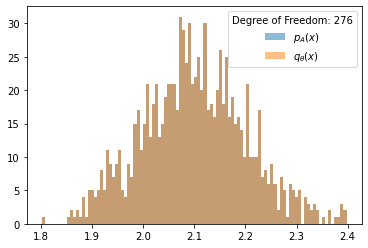

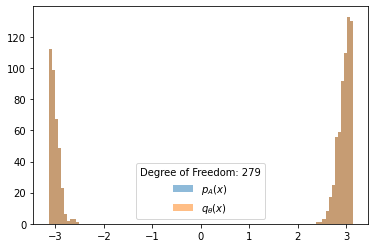

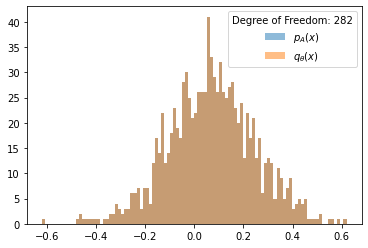

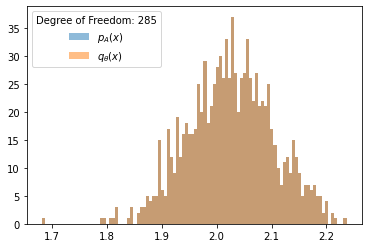

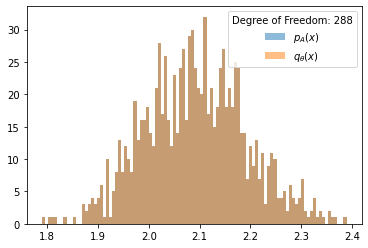

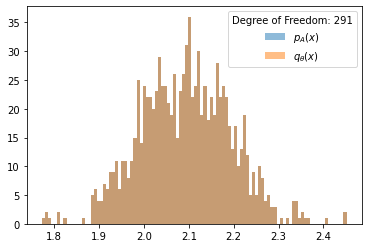

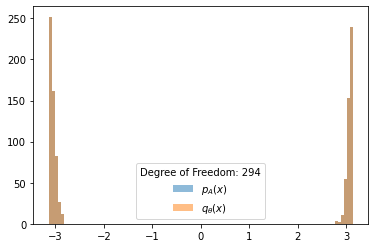

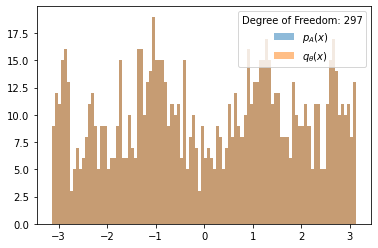

In [37]:
for index in range(0, 300, 1):
    if index%3==0:
        indx = str(index)
        plt.hist(whole[:, index], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
        plt.hist(original_np[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
        plt.legend(title = "Degree of Freedom: " + indx)
        plt.show()

### Work with Fast Transformers

https://fast-transformers.github.io/

In [54]:
from fast_transformers.builders import TransformerEncoderBuilder, TransformerDecoderBuilder

bert = TransformerEncoderBuilder.from_kwargs(
    n_layers=12,
    n_heads=12,
    query_dimensions=64,
    value_dimensions=64,
    feed_forward_dimensions=3072,
    attention_type="full", # change this to use another
                           # attention implementation
    activation="gelu"
).get()

y = bert(torch.rand(
    10,    # batch_size
    512,   # sequence length
    64*12  # features
))

ModuleNotFoundError: No module named 'fast_transformers'